In [49]:
import os
import cv2
import numpy as np 
from tqdm.auto import tqdm 
import pickle
from collections import defaultdict

c:\Users\samuel\pyenv\torch_gpu1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [80]:
REBUILD = False

CATS = '.\kagglecatsanddogs_5340\PetImages\Cat'
DOGS = '.\kagglecatsanddogs_5340\PetImages\Dog'
LABELS = {CATS:0, DOGS:1}
REV_LABELS = {0:'Cat', 1:'Dog'}

IMG_SIZE = 50

class DogsvCats:  
    def __init__(self, test_split=0.2, validation_split=0.1):
        self.test_split = test_split
        self.val_split = validation_split
        self.total_data = []
        self.train_data = []
        self.test_data = []
        self.validation_data = []
        self.counts = defaultdict(int)
    
    def train_val_test_split(self):
        for label in self.LABELS:
            print(label)
            for file in tqdm(os.listdir(label)):
                try:
                    image = cv2.imread(os.path.join(label, file), cv2.IMREAD_GRAYSCALE)                    
                    image = cv2.resize(image, (self.IMG_SIZE, self.IMG_SIZE))
                    self.total_data.append((np.array(image), np.eye(2)[self.LABELS[label]]))
                    self.counts[label] += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.total_data)
        
        print(self.counts)

        self.train_data = self.total_data[:-int(self.test_split * len(self.total_data))]
        self.test_data = self.total_data[-int(self.test_split * len(self.total_data)):]

        self.train_data = self.train_data[:-int(self.val_split * len(self.train_data))]
        self.validation_data = self.train_data[-int(self.val_split * len(self.train_data)):]

        print('Training Data:', len(self.train_data))
        print('Validation Data:', len(self.validation_data))
        print('Testing Data:', len(self.test_data))

        with open("./data/training_data.pkl", "wb") as f:
            pickle.dump(self.train_data, f)

        with open("./data/testing_data.pkl", "wb") as f:
            pickle.dump(self.test_data, f)

        with open("./data/validation_data.pkl", "wb") as f:
            pickle.dump(self.validation_data, f)

if REBUILD:
    dogsvcats = DogsvCats()
    dogsvcats.train_val_test_split()

In [25]:
training_data = np.load("./data/training_data.pkl", allow_pickle=True)
testing_data = np.load("./data/testing_data.pkl", allow_pickle=True)
validation_data = np.load("./data/validation_data.pkl", allow_pickle=True)

In [73]:
print(len(training_data))
print(len(testing_data))
print(len(validation_data))

17962
4989
1796


[[171 146 153 ... 202 190 208]
 [176 144 151 ... 200 191 208]
 [162 133 144 ... 201 191 206]
 ...
 [209 180 221 ... 183 150 157]
 [170 197 152 ... 182 158 210]
 [255 186 182 ... 132 191 235]]
[0. 1.]


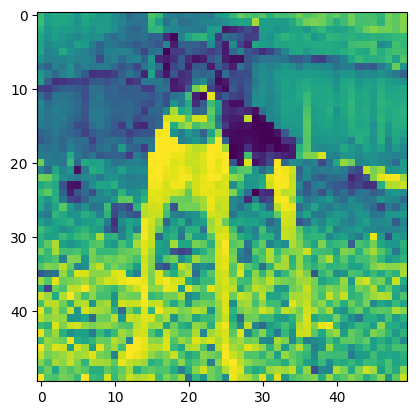

In [26]:
import matplotlib.pyplot as plt

print(training_data[0][0])
plt.imshow(training_data[0][0])

print(training_data[0][1])

In [45]:
import torch

IMG_SIZE = IMG_SIZE

X_train = torch.Tensor(np.array([img.reshape(1, IMG_SIZE, IMG_SIZE) for img, label in training_data]))/255.0
y_train = torch.Tensor(np.array([label for img, label in training_data]))

X_test = torch.Tensor(np.array([img.reshape(1, IMG_SIZE, IMG_SIZE) for img, label in testing_data]))/255.0
y_test = torch.Tensor(np.array([label for img, label in testing_data]))

X_val = torch.Tensor(np.array([img.reshape(1, IMG_SIZE, IMG_SIZE) for img, label in validation_data]))/255.0
y_val = torch.Tensor(np.array([label for img, label in validation_data]))

print('Training Data', X_train.shape, y_train.shape)
print('Testing Data', X_test.shape, y_test.shape)
print('Validation Data', X_val.shape, y_val.shape)

Training Data torch.Size([17962, 1, 50, 50]) torch.Size([17962, 2])
Testing Data torch.Size([4989, 1, 50, 50]) torch.Size([4989, 2])
Validation Data torch.Size([1796, 1, 50, 50]) torch.Size([1796, 2])


In [28]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else:
    device = torch.device('cpu')
    print('Running on GPU')

Running on GPU


In [72]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        out_size = self.forward(torch.randn(1, 1, 50, 50), True)[1]

        self.fc1 = nn.Linear(out_size, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x, find=False):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = x.flatten(start_dim=1)
        if find:
            return x.shape

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x, dim=1)

net = CNN()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_fun = nn.MSELoss()
print(net)


def train(X, y, X_val=X_val, y_val=y_val):
    BATCH_SIZE = 8
    EPOCHS = 4

    print(X.shape, y.shape, X_val.shape, y_val.shape)
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)           
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    for epoch in range(EPOCHS):
        train_acc_list = []
        train_loss_list = []
        for X_batch, y_batch in tqdm(dataloader):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            

            net.zero_grad()

            outputs = net(X_batch)
            loss = loss_fun(outputs, y_batch)

            train_acc_list.append(np.mean([int(torch.argmax(y_pred) == torch.argmax(y_true)) for y_pred, y_true in zip(outputs, y_batch)]))
            train_loss_list.append(float(loss))

            loss.backward()
            optimizer.step()
            
        train_acc = np.mean(train_acc_list)
        train_loss = np.mean(train_loss_list)

        val_outputs = net(X_val)
        val_acc = np.mean([int(torch.argmax(y_pred) == torch.argmax(y_true)) for y_pred, y_true in zip(val_outputs, y_val)])
        val_loss = float(loss_fun(val_outputs, y_val))

        print('Epoch', epoch+1, 'Train Accuracy:', round(train_acc*100, 3), 'Train Loss:', round(train_loss, 3), 'Val Accuracy:', round(val_acc*100, 3), 'Val Loss:', round(val_loss, 3))


train(X_train, y_train)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)
torch.Size([17962, 1, 50, 50]) torch.Size([17962, 2]) torch.Size([1796, 1, 50, 50]) torch.Size([1796, 2])


100%|██████████| 2246/2246 [00:09<00:00, 227.12it/s]


Epoch 1 Train Accuracy: 54.352 Train Loss: 0.246 Val Accuracy: 65.145 Val Loss: 0.222


100%|██████████| 2246/2246 [00:09<00:00, 239.53it/s]


Epoch 2 Train Accuracy: 65.411 Train Loss: 0.217 Val Accuracy: 73.274 Val Loss: 0.179


100%|██████████| 2246/2246 [00:09<00:00, 241.22it/s]


Epoch 3 Train Accuracy: 71.85 Train Loss: 0.186 Val Accuracy: 78.953 Val Loss: 0.152


100%|██████████| 2246/2246 [00:09<00:00, 243.04it/s]


Epoch 4 Train Accuracy: 75.941 Train Loss: 0.165 Val Accuracy: 82.127 Val Loss: 0.132


Dog
Cat


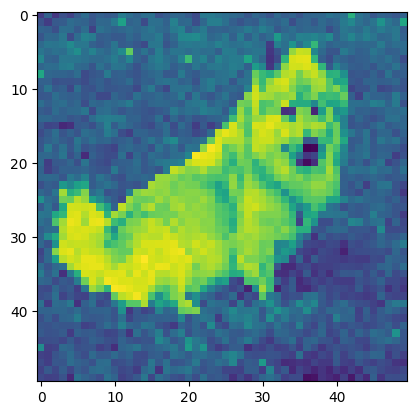

In [122]:
idx = 98

plt.imshow(X_test[idx].reshape(50,50,1))

print(REV_LABELS[int(torch.argmax(y_test[idx]))])

net.to('cpu')
with torch.no_grad():
    y_pred = REV_LABELS[int(torch.argmax(net(X_test[idx].reshape(-1, 1, 50, 50))))]

print(y_pred)

In [101]:
def test(X, y):
    net.to(device)
    BATCH_SIZE = 16

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)           

    test_acc = []
    test_loss = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = net(X_batch)
            loss = loss_fun(outputs, y_batch)

            test_acc.append(np.mean([int(torch.argmax(y_pred) == torch.argmax(y)) for y_pred, y in zip(outputs, y_batch)]))
            test_loss.append(float(loss))

        print('Testing Acc', round(np.mean(test_acc), 3)*100, 'Testing Loss', round(np.mean(test_loss), 3))

test(X_test, y_test)

Testing Acc 73.4 Testing Loss 0.179
